In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from database import model as m

secret = {
    "username": "admin",
    "password": "DRgPXv9mLuF0fsplWnox",
    "host": "database-2.cnzbp4ndrpos.eu-west-1.rds.amazonaws.com",
    "port": "1433"
}

engine = create_engine(
    'mssql+pymssql://' +
    secret['username'] + ':' + secret['password'] + '@' + secret['host'] + ':' +
    str(secret['port']) + '/Corona'

)

session = sessionmaker()(bind=engine)

In [3]:
df_provices = pd.read_csv("https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_confirmed.csv")
df_provices["date"] = pd.to_datetime(df_provices["date"], dayfirst=True)
df_provices = df_provices.melt(id_vars = ["date","YYYYMMDD"])

conf_int_list = [int(x)  if np.isnan(x) == False else np.nan for x in df_provices["value"]]
conf_series = pd.Series(conf_int_list)
clean_conf = conf_series.astype(object).where(pd.notnull(conf_series), None)

In [7]:
Upload_Country = "South Africa"
level = "Provincial"
Upload_Country_id = session.query(m.Country).filter(m.Country.country == Upload_Country).first().id
#connection=engine.connect()
for i in range(len(df_provices)):
    
    Location = session.query(m.Location).filter(m.Location.location == df_provices["variable"][i]).first()
 
    CasesLocal = m.CasesLocal( 
                        date = df_provices["date"][i],
                        confirmed = clean_conf[i],
                        location_id = Location.id
    )

    session.add(CasesLocal)    
    #connection.execute("with cte as(select date, confirmed, location_id, row_number() over(partition by date, confirmed, location_id  order by date, confirmed, location_id) row_num from CasesLocal) delete from cte where row_num > 1")

session.commit()
session.close()

In [9]:
confirmed_results = pd.read_sql_table("CasesLocal", engine)

In [10]:
confirmed_results

,id,date,confirmed,location_id
0,1,2020-03-05,0.0,1
1,2,2020-03-07,0.0,1
2,3,2020-03-08,0.0,1
3,4,2020-03-09,0.0,1
4,5,2020-03-11,0.0,1
...,...,...,...,...
380,381,2020-04-06,1686.0,11
381,382,2020-04-07,1749.0,11
382,383,2020-04-08,1845.0,11
383,384,2020-04-09,1934.0,11


In [11]:
confirmed_results['daily difference'] = confirmed_results['confirmed'].diff().fillna(0).astype(np.int)

In [12]:
confirmed_results

,id,date,confirmed,location_id,daily difference
0,1,2020-03-05,0.0,1,0
1,2,2020-03-07,0.0,1,0
2,3,2020-03-08,0.0,1,0
3,4,2020-03-09,0.0,1,0
4,5,2020-03-11,0.0,1,0
...,...,...,...,...,...
380,381,2020-04-06,1686.0,11,31
381,382,2020-04-07,1749.0,11,63
382,383,2020-04-08,1845.0,11,96
383,384,2020-04-09,1934.0,11,89


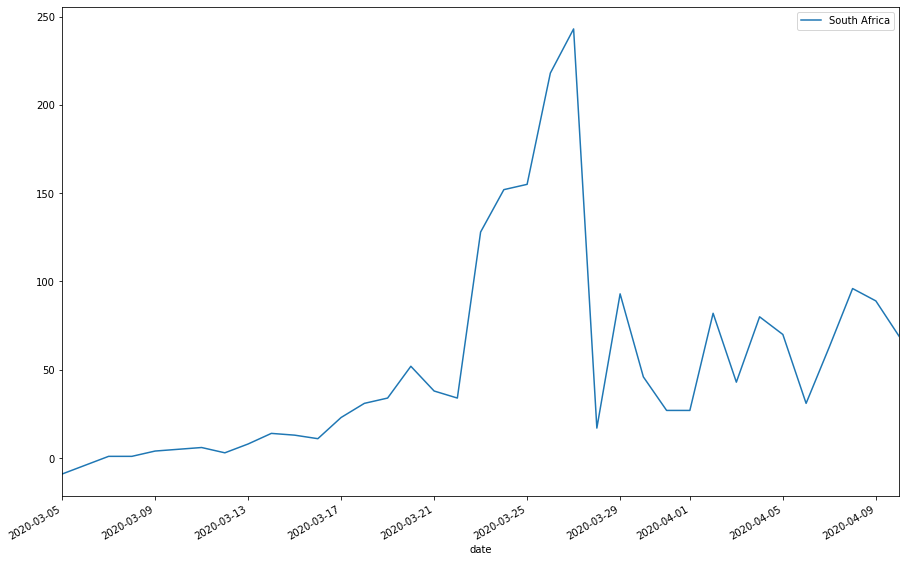

In [7]:
confirmed_results = confirmed_results.groupby('date').last().reset_index()
confirmed_results[confirmed_results['confirmed'] > 0].plot(x='date', y='daily difference' , label='South Africa', figsize=(15,10))

In [14]:
confirmed_results['log'] = np.log(confirmed_results['confirmed'])

C:\Users\kopan\Anaconda3\lib\site-packages\pandas\core\series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


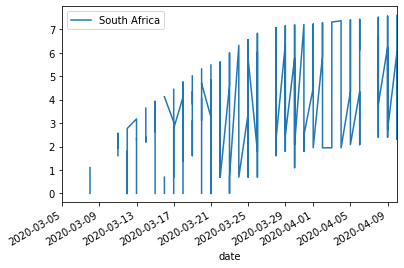

In [16]:
confirmed_results.plot(x='date', y='log' , label='South Africa', figsize=(15,10))

In [17]:
confirmed_results_g = pd.read_sql_table("CasesLocal", engine)
confirmed_results_g

,id,date,confirmed,deaths,recovered,country_id
0,1,2020-02-24,1,0,None,1
1,2,2020-02-25,1,0,None,1
2,3,2020-02-26,1,0,None,1
3,4,2020-02-27,1,0,None,1
4,5,2020-02-28,1,0,None,1
...,...,...,...,...,...,...
6495,6496,2020-04-03,9,1,None,184
6496,6497,2020-04-04,9,1,None,184
6497,6498,2020-04-05,9,1,None,184
6498,6499,2020-04-06,10,1,None,184


In [3]:
df_C = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")

In [4]:
df_C

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20
0,NaN,Afghanistan,33.00000,65.000000,0,0,0,0,0,0,...,174,237,273,281,299,349,367,423,444,484
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,243,259,277,304,333,361,377,383,400,409
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,716,847,986,1171,1251,1320,1423,1468,1572,1666
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,376,390,428,439,466,501,525,545,564,583
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,7,8,8,8,10,14,16,17,19,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258,Falkland Islands (Malvinas),United Kingdom,-51.79630,-59.523600,0,0,0,0,0,0,...,0,0,0,0,1,2,2,2,5,5
259,Saint Pierre and Miquelon,France,46.88520,-56.315900,0,0,0,0,0,0,...,0,0,0,0,0,1,1,1,1,1
260,NaN,South Sudan,6.87700,31.307000,0,0,0,0,0,0,...,0,0,0,0,0,1,1,2,2,3
261,NaN,Western Sahara,24.21550,-12.885800,0,0,0,0,0,0,...,0,0,0,0,0,4,4,4,4,4


In [5]:
df_C = df_C.melt(id_vars = ["Country/Region","Lat","Long","Province/State"])


In [6]:
df_C_country_level = df_C.groupby(["Country/Region","variable"]).sum()
df_C_country_level

Lat  Long  value
Country/Region variable                   
Afghanistan    1/22/20   33.0  65.0      0
               1/23/20   33.0  65.0      0
               1/24/20   33.0  65.0      0
               1/25/20   33.0  65.0      0
               1/26/20   33.0  65.0      0
...                       ...   ...    ...
Zimbabwe       4/5/20   -20.0  30.0      9
               4/6/20   -20.0  30.0     10
               4/7/20   -20.0  30.0     11
               4/8/20   -20.0  30.0     11
               4/9/20   -20.0  30.0     11

[14536 rows x 3 columns]

In [7]:
df_C_country_level = df_C_country_level.reset_index()
df_C_country_level

,Country/Region,variable,Lat,Long,value
0,Afghanistan,1/22/20,33.0,65.0,0
1,Afghanistan,1/23/20,33.0,65.0,0
2,Afghanistan,1/24/20,33.0,65.0,0
3,Afghanistan,1/25/20,33.0,65.0,0
4,Afghanistan,1/26/20,33.0,65.0,0
...,...,...,...,...,...
14531,Zimbabwe,4/5/20,-20.0,30.0,9
14532,Zimbabwe,4/6/20,-20.0,30.0,10
14533,Zimbabwe,4/7/20,-20.0,30.0,11
14534,Zimbabwe,4/8/20,-20.0,30.0,11


In [8]:
df_C_country_level["Date"] = df_C_country_level.variable.apply(lambda x: pd.to_datetime(x))
df_C_country_level = df_C_country_level[df_C_country_level["value"]!=0]
df_C_country_level

,Country/Region,variable,Lat,Long,value,Date
26,Afghanistan,2/24/20,33.0,65.0,1,2020-02-24
27,Afghanistan,2/25/20,33.0,65.0,1,2020-02-25
28,Afghanistan,2/26/20,33.0,65.0,1,2020-02-26
29,Afghanistan,2/27/20,33.0,65.0,1,2020-02-27
30,Afghanistan,2/28/20,33.0,65.0,1,2020-02-28
...,...,...,...,...,...,...
14531,Zimbabwe,4/5/20,-20.0,30.0,9,2020-04-05
14532,Zimbabwe,4/6/20,-20.0,30.0,10,2020-04-06
14533,Zimbabwe,4/7/20,-20.0,30.0,11,2020-04-07
14534,Zimbabwe,4/8/20,-20.0,30.0,11,2020-04-08


In [9]:
df_D = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")
df_D = df_D.melt(id_vars = ["Country/Region","Lat","Long","Province/State"])

df_D_country_level = df_D.groupby(["Country/Region","variable"]).sum()

df_D_country_level = df_D_country_level.reset_index()

df_D_country_level["Date"] = df_D_country_level.variable.apply(lambda x: pd.to_datetime(x))

df_D_country_level = df_D_country_level[df_D_country_level["value"]!=0]
df_D_country_level

,Country/Region,variable,Lat,Long,value,Date
53,Afghanistan,3/22/20,33.0,65.0,1,2020-03-22
54,Afghanistan,3/23/20,33.0,65.0,1,2020-03-23
55,Afghanistan,3/24/20,33.0,65.0,1,2020-03-24
56,Afghanistan,3/25/20,33.0,65.0,2,2020-03-25
57,Afghanistan,3/26/20,33.0,65.0,4,2020-03-26
...,...,...,...,...,...,...
14531,Zimbabwe,4/5/20,-20.0,30.0,1,2020-04-05
14532,Zimbabwe,4/6/20,-20.0,30.0,1,2020-04-06
14533,Zimbabwe,4/7/20,-20.0,30.0,2,2020-04-07
14534,Zimbabwe,4/8/20,-20.0,30.0,3,2020-04-08


In [10]:
df_merge = df_C_country_level.merge(df_D_country_level ,on = ["Country/Region","Date"],how = "left")
df_merge

,Country/Region,variable_x,Lat_x,Long_x,value_x,Date,variable_y,Lat_y,Long_y,value_y
0,Afghanistan,2/24/20,33.0,65.0,1,2020-02-24,NaN,NaN,NaN,NaN
1,Afghanistan,2/25/20,33.0,65.0,1,2020-02-25,NaN,NaN,NaN,NaN
2,Afghanistan,2/26/20,33.0,65.0,1,2020-02-26,NaN,NaN,NaN,NaN
3,Afghanistan,2/27/20,33.0,65.0,1,2020-02-27,NaN,NaN,NaN,NaN
4,Afghanistan,2/28/20,33.0,65.0,1,2020-02-28,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
6863,Zimbabwe,4/5/20,-20.0,30.0,9,2020-04-05,4/5/20,-20.0,30.0,1.0
6864,Zimbabwe,4/6/20,-20.0,30.0,10,2020-04-06,4/6/20,-20.0,30.0,1.0
6865,Zimbabwe,4/7/20,-20.0,30.0,11,2020-04-07,4/7/20,-20.0,30.0,2.0
6866,Zimbabwe,4/8/20,-20.0,30.0,11,2020-04-08,4/8/20,-20.0,30.0,3.0


In [11]:
def error(x):
    if pd.isnull(x):
        return 0
    else:
        return x
    
df_merge["deaths"] = df_merge.value_y.apply(lambda x: error(x))

In [29]:
df_merge["Date"]

0      2020-02-24
1      2020-02-25
2      2020-02-26
3      2020-02-27
4      2020-02-28
          ...    
6863   2020-04-05
6864   2020-04-06
6865   2020-04-07
6866   2020-04-08
6867   2020-04-09
Name: Date, Length: 6868, dtype: datetime64[ns]

In [30]:
df_merge["value_x"]

0        1
1        1
2        1
3        1
4        1
        ..
6863     9
6864    10
6865    11
6866    11
6867    11
Name: value_x, Length: 6868, dtype: int64

In [31]:
df_merge["deaths"]

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
6863    1.0
6864    1.0
6865    2.0
6866    3.0
6867    3.0
Name: deaths, Length: 6868, dtype: float64

In [12]:
for i in range(len(df_merge)):
    
    ## Check Country exisits
    Country = session.query(m.Country).filter(m.Country.country == df_merge["Country/Region"][i]).first()
    #if Country is None:
        #Country = m.Country(country = df_merge["Country/Region"][i])
        #session.add(Country)
        #session.commit()
    
    CasesGlobal = m.CasesGlobal( 
                        date = df_merge["Date"][i],
                        confirmed = int(df_merge["value_x"][i]),
                        deaths = int(df_merge["deaths"][i]),
                        country_id = Country.id
    )
    
    session.add(CasesGlobal)
    
session.commit()
session.close()

ProgrammingError: (raised as a result of Query-invoked autoflush; consider using a session.no_autoflush block if this flush is occurring prematurely)
(pymssql.ProgrammingError) (207, b"Invalid column name 'recovered'.DB-Lib error message 20018, severity 16:\nGeneral SQL Server error: Check messages from the SQL Server\nDB-Lib error message 20018, severity 16:\nGeneral SQL Server error: Check messages from the SQL Server\n")
[SQL: INSERT INTO [CasesGlobal] (date, confirmed, deaths, recovered, country_id) OUTPUT inserted.id VALUES (%(date)s, %(confirmed)s, %(deaths)s, %(recovered)s, %(country_id)s)]
[parameters: {'date': Timestamp('2020-02-24 00:00:00'), 'confirmed': 1, 'deaths': 0, 'recovered': None, 'country_id': 1}]
(Background on this error at: http://sqlalche.me/e/f405)